In [67]:
import logging
import mmap
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np
import os

In [68]:
logger = logging.getLogger(__name__)

In [78]:
def compute_seq_id(hit, or_id=0):
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id)

In [94]:
# Adapted from Bob's RICHPID repo
class RICHDataset(Dataset):
    """RICH pytorch dataset."""
    def check_dataset(self,name,obj):
        """"Check the input file fromat."""
        if isinstance(obj, h5py.Dataset):
            print(name,obj.shape)
            print(name,obj.chunks)
            print(name,obj.compression)
            print(name,obj.dtype)
            #raise BadDataFormat('Unexpected data format, check the logs.')
            
    def __init__(self, dset_path):
        # We don't attempt to catch exception here, crash if we cannot open the file.
        with h5py.File(dset_path,'r') as dfile:

            for key in dfile.attrs:
                logger.info('%s: %s', key,dfile.attrs[key])

            # We don't attempt to catch exception here,
            # crash if the data format is not what we were expecting.
            dfile.visititems(self.check_dataset)

            # Load the hit map into memory
            self.hit_mapping = np.asarray(dfile['HitMapping'][:])
            logger.info('hit map size: %i bytes',self.hit_mapping.nbytes)
            self.N = len(self.hit_mapping) - 1 # !!! The last cell is the sentinel !!!

            # Get the info we need to memory map the hits
            hit_ds = dfile['Hits']
            hit_offset = hit_ds.id.get_offset()
            hit_dtype = hit_ds.dtype
            hit_shape = hit_ds.shape
            hit_length = np.prod(hit_shape)
            # Get the info we need to memory map the events
            event_ds = dfile['Events']
            event_offset = event_ds.id.get_offset()
            event_dtype = event_ds.dtype
            event_shape = event_ds.shape
            event_length = np.prod(event_shape)

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with open(dset_path, "rb") as fh:
            fileno = fh.fileno()
            mapping = mmap.mmap(fileno, 0, access=mmap.ACCESS_READ)
            self.hit_array = np.frombuffer(mapping, dtype=hit_dtype, count=hit_length,
                                            offset=hit_offset).reshape(hit_shape)
            logger.info('hit array mmap size: %i bytes', self.hit_array.nbytes)
            self.event_array = np.frombuffer(mapping, dtype=event_dtype, count=event_length,
                                            offset=event_offset).reshape(event_shape)
            logger.info('event array mmap size: %i bytes', self.event_array.nbytes)

    
    def get_position_data(self):
        return np.load(os.path.join("tools", "rich_pmt_positions.npy"))
    
    def get_single_event_input(self, event_number):
        
        # get hits for the event
        hit_in=self.hit_mapping[event_number]
        hit_in_end=self.hit_mapping[event_number + 1] - 1 
        hits = self.hit_array[hit_in: hit_in_end]
        
        # load position map data
        position_map = self.get_position_data()
        
        # create index 
        index = compute_seq_id(hits)
        event_pos = position_map[index]
        
        return event_pos
    
    def get_input_data(self):
        get_event_input_ = np.vectorize(self.get_single_event_input)
        return get_event_input_([i for i in range(self.N)])
    
        

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if not isinstance(idx,int):
            raise NotImplementedError(f'{type(idx)} type key access is not implemented')
        if idx < 0:
            raise NotImplementedError('negative index access is not implemented')
        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx+1] # This ok, we have the sentinel
        return (torch.tensor(self.hit_array[idx_from:idx_to]['hit_time']),
                torch.tensor(self.event_array[idx]['chod_time']),
                torch.tensor(self.event_array[idx]['ring_centre_pos'])
                )

In [95]:
dset = RICHDataset("/data/bvelghe/capstone2022/A/Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5")

Events (128982,)
Events None
Events None
Events {'names': ['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum', 'chod_time', 'ring_radius', 'ring_centre_pos', 'ring_likelihood'], 'formats': ['<i4', '<i4', '<i8', '<i4', '<f4', '<f4', '<f4', ('<f4', (2,)), ('<f4', (3,))], 'offsets': [0, 4, 8, 16, 20, 24, 28, 32, 40], 'itemsize': 56}
HitMapping (128983,)
HitMapping (128982,)
HitMapping gzip
HitMapping int64
Hits (4689741,)
Hits None
Hits None
Hits [('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')]


In [96]:
dset.hit_array

array([(1, 7, 37, 1,  6.4918146), (1, 4, 41, 1,  6.334047 ),
       (1, 0, 41, 1,  6.0296416), ..., (1, 0, 41, 1, 17.56226  ),
       (1, 0, 42, 1, 17.81694  ), (0, 0,  1, 1, -9.147976 )],
      dtype=[('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')])

In [99]:
data = dset.get_single_event_input(10)

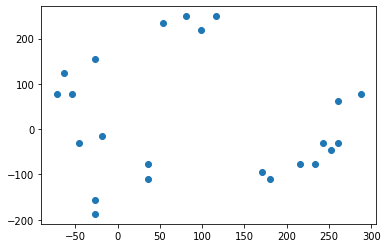

In [100]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])
plt.show()

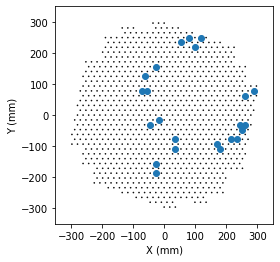

In [104]:
from event_display.plot_event import draw_pmt_pos
fig = plt.figure()
ax = fig.subplots()
ax.set_aspect('equal')
ax.set_xlim(-350,350) # mm
ax.set_ylim(-350,350) # mm
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
draw_pmt_pos(ax, dset.get_position_data())
plt.scatter(data[:,0], data[:,1])
plt.show()